# Import libraries

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from google.colab import drive, files
import os
import matplotlib.dates as mdates

# Set up directory

In [ ]:
# Set folder name
folder_name = "NLP Project_DS397"

# Create path and folder
folder_path = f"/content/drive/MyDrive/{folder_name}"
os.makedirs(folder_path, exist_ok=True)

# Change working directory
os.chdir(folder_path)

# Check directory
print("Working directory ready at:", os.getcwd())

Working directory ready at: /content/drive/MyDrive/NLP Project_DS397


# Upload clean text data

In [ ]:
# Upload the local file to drive directory
uploaded = files.upload()

# Get uploaded file name
file_name = list(uploaded.keys())[0]

Saving output_clean.csv to output_clean (1).csv


# Daily PSEi data

## Load data

In [ ]:
# Identify PSEI data in Yahoo finance
ticker = "PSEI.PS"

# Load PSEI data from Yahoo finance
df = yf.download(ticker, start="2014-01-01", end="2025-10-31", progress=False)

# Reset to use date variable, converting the Date index into a column
df = df.reset_index()

# Flatten MultiIndex columns (yf.download often returns MultiIndex)
df.columns = df.columns.droplevel(1)

# Check data
print(df.head())
print(df.tail())

Price       Date        Close         High          Low         Open  Volume
0     2014-01-02  5982.721191  5982.721191  5922.197206  5922.197206   80300
1     2014-01-03  5946.400879  5969.824542  5902.252077  5969.824542   74900
2     2014-01-06  5984.271484  5991.439563  5930.984892  5948.860667   77800
3     2014-01-07  5945.911133  5990.389931  5945.191591  5984.641409   68800
4     2014-01-08  5984.940918  5993.528553  5941.152374  5946.770558   55900
Price       Date        Close         High          Low         Open  Volume
2880  2025-10-24  5988.020020  6069.890137  5980.350098  6062.350098  191600
2881  2025-10-27  5933.759766  5996.419922  5895.020020  5996.419922   86600
2882  2025-10-28  5953.160156  5961.490234  5926.540039  5934.390137   63400
2883  2025-10-29  5963.770020  6021.290039  5959.020020  5961.279785   89300
2884  2025-10-30  5929.680176  5972.450195  5905.270020  5961.560059   88800


/tmp/ipython-input-916230199.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2014-01-01", end="2025-10-31", progress=False)


## Save data

In [ ]:
# Save data
df.to_csv("PSEI_daily.csv")

## Data visualization

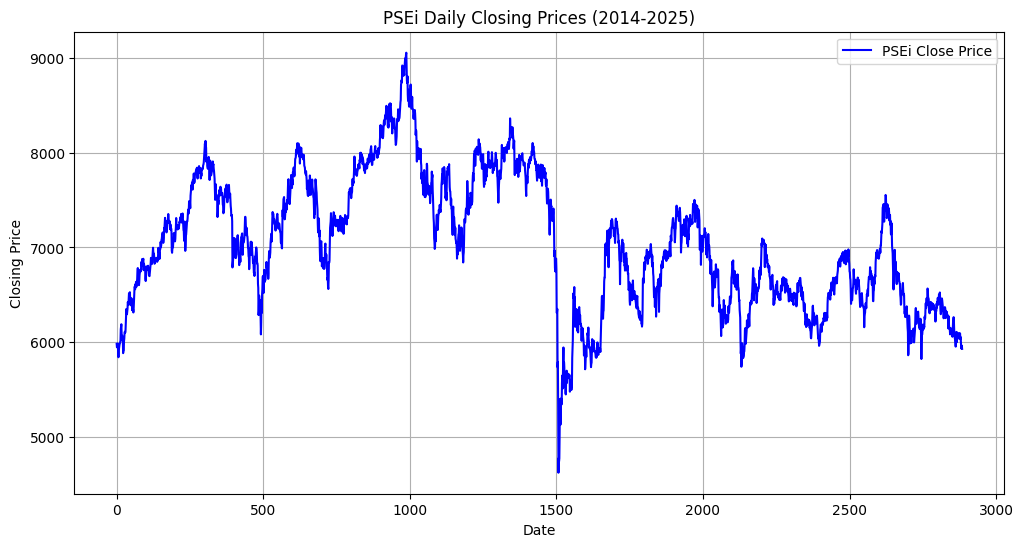

In [ ]:
# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='PSEi Close Price', color='blue')
plt.title('PSEi Daily Closing Prices (2014-2025)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

# Sentiment Scores

## Load data

In [ ]:
# Load clean business headline data
df_sentiment = pd.read_csv(file_name)

# Change data type
df_sentiment["date"] = pd.to_datetime(df_sentiment["date"], format="%d-%b-%y")

# Check data
print(df_sentiment.head())

# Trim dat [Remove to use full data]
#df_sentiment = df_sentiment.iloc[:200]

        date                                              title  year  month  \
0 2025-10-31  Philippines sees trade deficit narrow in Septe...  2025     10   
1 2025-10-31               Peso, PSEi drop with easing in doubt  2025     10   
2 2025-10-31  Fed lowers rates but Powell suggests move may ...  2025     10   
3 2025-10-31  Trump shaves China tariffs in deal with Xi on ...  2025     10   
4 2025-10-31  Government trims outstanding debt to P17.65T i...  2025     10   

   day  
0   31  
1   31  
2   31  
3   31  
4   31  


## Set up model

In [ ]:
# Load model
model_name = "tabularisai/ModernFinBERT"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

## Generate sentiment scores

### Define scoring function

In [ ]:
# Define sentiment scorer
def finbert_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    outputs = model(**inputs)

    # Convert logits to probability via softmax
    probs = F.softmax(outputs.logits, dim=1).detach().numpy()[0]

    labels = ["negative", "neutral", "positive"]

    return {
        "sentiment": labels[probs.argmax()],
        "negative_score": float(probs[0]),
        "neutral_score": float(probs[1]),
        "positive_score": float(probs[2])
    }

### Apply model

In [ ]:
# Run scorer
results = df_sentiment["title"].apply(finbert_score)

# Convert results to DataFrame + merge
results_df = pd.DataFrame(list(results))
df_sentiment_v2 = pd.concat([df_sentiment, results_df], axis=1)

# Check data
print(df_sentiment_v2.head())

        date                                              title  year  month  \
0 2025-10-31  Philippines sees trade deficit narrow in Septe...  2025     10   
1 2025-10-31               Peso, PSEi drop with easing in doubt  2025     10   
2 2025-10-31  Fed lowers rates but Powell suggests move may ...  2025     10   
3 2025-10-31  Trump shaves China tariffs in deal with Xi on ...  2025     10   
4 2025-10-31  Government trims outstanding debt to P17.65T i...  2025     10   

   day sentiment  negative_score  neutral_score  positive_score  
0   31  positive        0.030444       0.026439        0.943117  
1   31  negative        0.951726       0.037357        0.010917  
2   31  negative        0.640162       0.348440        0.011398  
3   31   neutral        0.076924       0.573880        0.349196  
4   31   neutral        0.246589       0.612649        0.140762  


## Data visualization

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


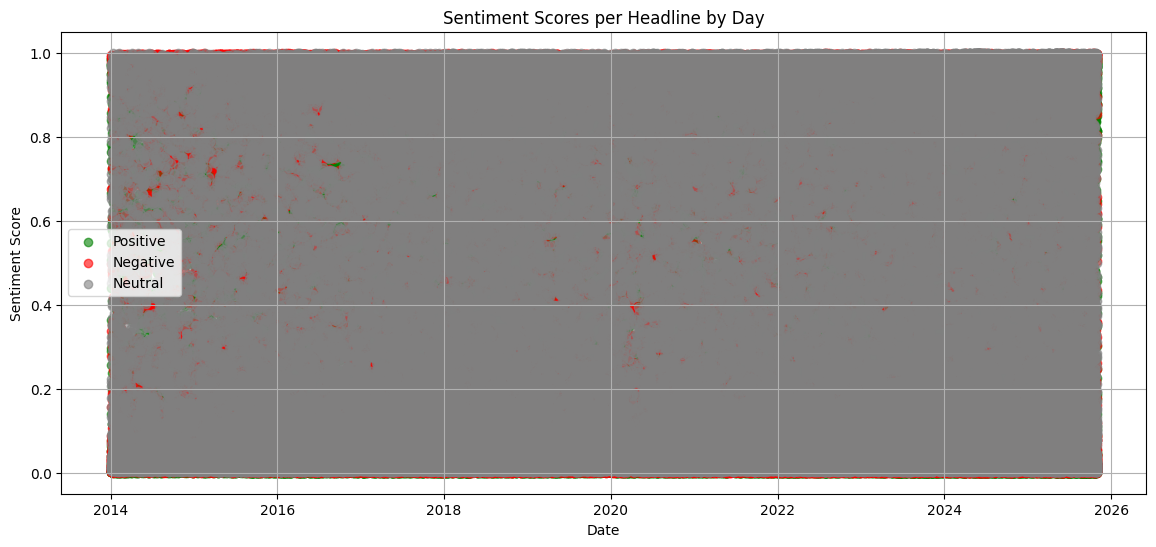

In [ ]:
plt.figure(figsize=(14,6))

# Plot each sentiment score separately
plt.scatter(df_sentiment_v2["date"], df_sentiment_v2["positive_score"], label="Positive", color="green", alpha=0.6)
plt.scatter(df_sentiment_v2["date"], df_sentiment_v2["negative_score"], label="Negative", color="red", alpha=0.6)
plt.scatter(df_sentiment_v2["date"], df_sentiment_v2["neutral_score"], label="Neutral", color="gray", alpha=0.6)

plt.title("Sentiment Scores per Headline by Day")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True)
plt.show()

# Merge PSEi and sentiment score

In [ ]:
# Merge data
merged_df = pd.merge(
    df_sentiment_v2,
    df,
    left_on="date",
    right_on="Date",
    how="left"  # keep all news rows; missing market data will be NaN
)

# Drop redundant variable
merged_df = merged_df.drop(columns=["Date"])

# Check data
print(merged_df.head())

        date                                              title  year  month  \
0 2025-10-31  Philippines sees trade deficit narrow in Septe...  2025     10   
1 2025-10-31               Peso, PSEi drop with easing in doubt  2025     10   
2 2025-10-31  Fed lowers rates but Powell suggests move may ...  2025     10   
3 2025-10-31  Trump shaves China tariffs in deal with Xi on ...  2025     10   
4 2025-10-31  Government trims outstanding debt to P17.65T i...  2025     10   

   day sentiment  negative_score  neutral_score  positive_score  Close  High  \
0   31  positive        0.030444       0.026439        0.943117    NaN   NaN   
1   31  negative        0.951726       0.037357        0.010917    NaN   NaN   
2   31  negative        0.640162       0.348440        0.011398    NaN   NaN   
3   31   neutral        0.076924       0.573880        0.349196    NaN   NaN   
4   31   neutral        0.246589       0.612649        0.140762    NaN   NaN   

   Low  Open  Volume  
0  NaN   NaN   

In [ ]:
# Save data
merged_df.to_csv("merged_df.csv")

## Data visualization

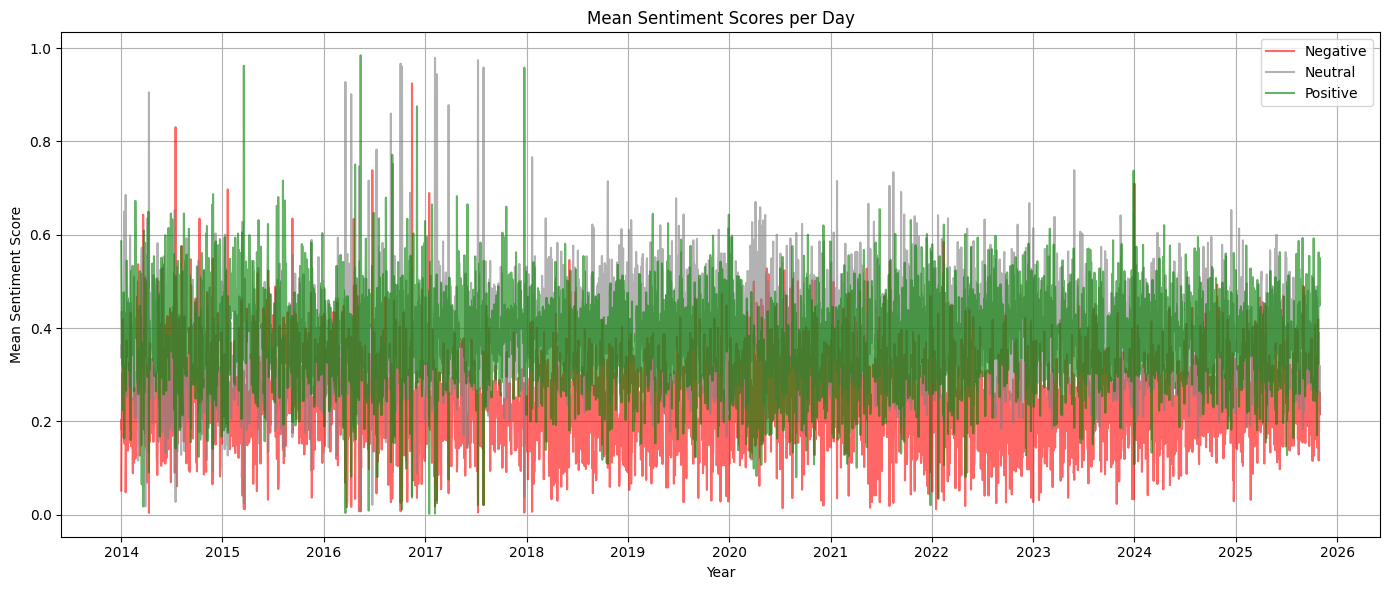

In [ ]:
# Get mean score for each sentiment type
vis_df = merged_df.groupby("date")[["negative_score", "neutral_score", "positive_score"]].mean().reset_index()
vis_df["date"] = pd.to_datetime(vis_df["date"])

# Sort by date
vis_df = vis_df.sort_values("date")

# Plot data
plt.figure(figsize=(14,6), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

plt.plot(vis_df["date"], vis_df["negative_score"], label="Negative", color="red", alpha=0.6)
plt.plot(vis_df["date"], vis_df["neutral_score"], label="Neutral", color="gray", alpha=0.6)
plt.plot(vis_df["date"], vis_df["positive_score"], label="Positive", color="green", alpha=0.6)

# Year-only ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.title("Mean Sentiment Scores per Day")
plt.xlabel("Year")
plt.ylabel("Mean Sentiment Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

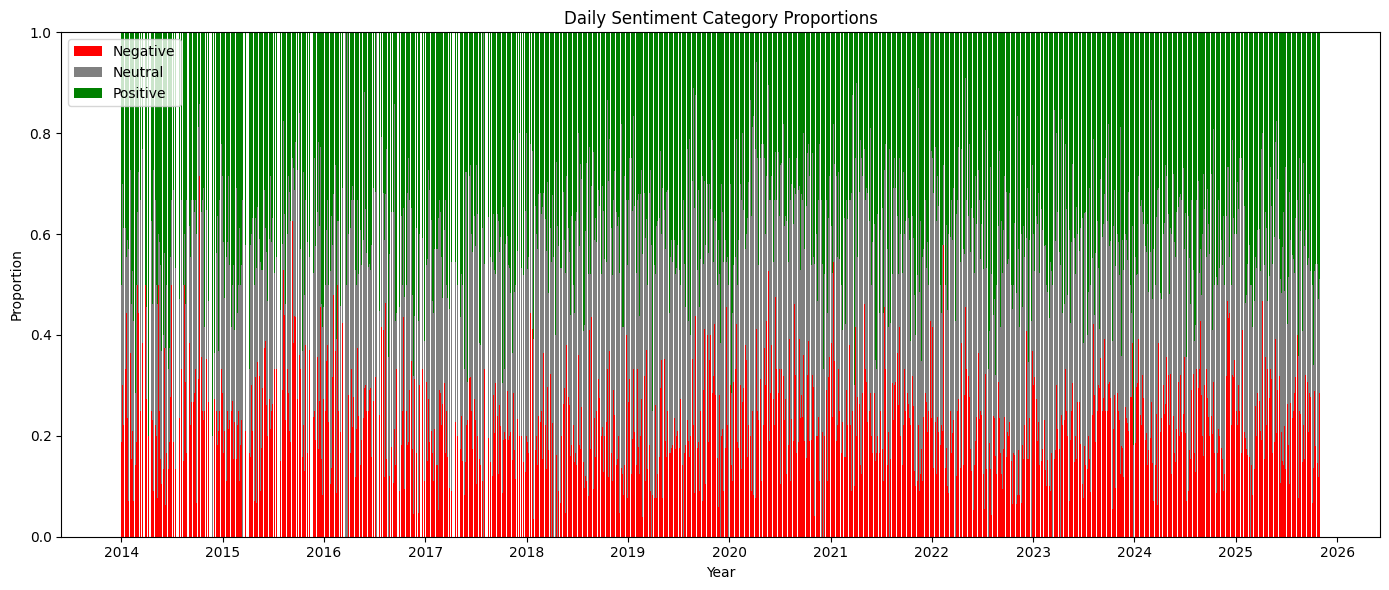

In [ ]:
# Count sentiment categories per date
stack_df = (
    merged_df.groupby(["date", "sentiment"])
    .size()
    .unstack(fill_value=0)
)

# Ensure sorted dates
stack_df = stack_df.sort_index()

# Convert counts to proportions
prop_df = stack_df.div(stack_df.sum(axis=1), axis=0)

# Build figure and axis
fig, ax = plt.subplots(figsize=(14,6))

# Convert index to datetime for tick formatting
prop_df.index = pd.to_datetime(prop_df.index)

# Plot stacked bars manually using Matplotlib
ax.bar(prop_df.index, prop_df["negative"], color="red", label="Negative")
ax.bar(prop_df.index, prop_df["neutral"], bottom=prop_df["negative"], color="gray", label="Neutral")
ax.bar(prop_df.index, prop_df["positive"],
       bottom=prop_df["negative"] + prop_df["neutral"],
       color="green", label="Positive")

# Year-only ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.title("Daily Sentiment Category Proportions")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Validate dates

## Identify missing dates

In [ ]:
# Covert date
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Creat date range
full_range = pd.date_range(
    start=merged_df["date"].min(),
    end=merged_df["date"].max(),
    freq="D"
)

missing_dates = full_range.difference(merged_df["date"].unique())

print("Missing Dates:")
print(missing_dates)

#Save file
missing_dates.to_series().to_csv("missing_dates.csv", index=False)

Missing Dates:
DatetimeIndex(['2014-01-04', '2014-01-11', '2014-01-18', '2014-01-25',
               '2014-02-01', '2014-02-08', '2014-02-15', '2014-02-22',
               '2014-03-01', '2014-03-08',
               ...
               '2017-12-03', '2017-12-10', '2017-12-17', '2017-12-31',
               '2018-01-07', '2018-01-14', '2018-01-19', '2018-01-28',
               '2018-02-04', '2019-10-12'],
              dtype='datetime64[ns]', length=200, freq=None)
